# **Social Influence Simulation in a General Election**

## **Student Information**

<div align="center">

| **Student Name** | **Student ID** |
|------------------|----------------|
| To Bao Chau      | A0276224E      |

</div>



## **Import library**

In [47]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
from numba import njit
from numba.typed import List



## **Question 1**

**📂 Read the Data File**

In [32]:
# Load 'people.csv' into a pandas dataframe
data = pd.read_csv('people.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,257,258,259,260,261,262,263,264
0,1,3,2,3,1,2,3,3,33,49,...,0,0,0,0,0,0,0,0,0,0
1,2,3,2,3,3,2,3,3,26,39,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,2,3,2,1,3,52,53,...,0,0,0,0,0,0,0,0,0,0
3,4,3,2,3,2,2,2,3,8,13,...,0,0,0,0,0,0,0,0,0,0
4,5,3,1,1,1,2,3,3,6,8,...,0,0,0,0,0,0,0,0,0,0


**📊 Data Exploration and Manipulation**

1. Check data columns

In [33]:
# Check data columns
data.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264],
      dtype='int64', length=265)

Since the dataset lacks column headers, we will assign appropriate column names (as specified in the project file) to facilitate better analysis.

2. Check data information

In [34]:
# Check data information
print("Data Information:")
data.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 265 entries, 0 to 264
dtypes: int64(265)
memory usage: 8.1 MB


All columns are in int type

3. Check missing values

In [35]:
# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())
print("\nTotal Missing Values:")
print(data.isnull().sum().sum())



Missing Values per Column:
0      0
1      0
2      0
3      0
4      0
      ..
260    0
261    0
262    0
263    0
264    0
Length: 265, dtype: int64

Total Missing Values:
0


There are no missing values in data set

4. Assign column names

In [36]:
# Determine the total number of columns in the dataset
num_cols = data.shape[1]           

# Calculate the number of friend columns
num_friend_cols = num_cols - 8  

# Define the expected number col_names for the DataFrame
col_names = [
    'ID', 
    'party', 
    'decision', 
    'hobby_music', 
    'hobby_car', 
    'hobby_sports', 
    'hobby_movie', 
    'hobby_food'
] + [f'friend_{i}' for i in range(1, num_friend_cols + 1)]

# Assign these column names
data.columns = col_names

# Inspect the DataFrame
data

,ID,party,decision,hobby_music,hobby_car,hobby_sports,hobby_movie,hobby_food,friend_1,friend_2,...,friend_248,friend_249,friend_250,friend_251,friend_252,friend_253,friend_254,friend_255,friend_256,friend_257
0,1,3,2,3,1,2,3,3,33,49,...,0,0,0,0,0,0,0,0,0,0
1,2,3,2,3,3,2,3,3,26,39,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,2,3,2,1,3,52,53,...,0,0,0,0,0,0,0,0,0,0
3,4,3,2,3,2,2,2,3,8,13,...,0,0,0,0,0,0,0,0,0,0
4,5,3,1,1,1,2,3,3,6,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,1,1,1,2,2,3,2,17,32,...,0,0,0,0,0,0,0,0,0,0
3996,3997,1,1,2,1,2,3,3,3,31,...,0,0,0,0,0,0,0,0,0,0
3997,3998,2,2,3,1,1,2,2,13,37,...,0,0,0,0,0,0,0,0,0,0
3998,3999,1,1,3,3,3,3,3,12,29,...,0,0,0,0,0,0,0,0,0,0


## **Question 2**

**Analise the graph, and state which candidate will win the race on the first day i.e. before any changes.**

In [37]:
hobby_cols = ['hobby_music', 'hobby_car', 'hobby_sports', 'hobby_movie', 'hobby_food']
# Create an empty undirected graph
G = nx.Graph()

# Add nodes with attributes
for idx, row in data.iterrows():
    voter_id = int(row['ID'])
    # Save party, decision, and hobbies as node attributes
    G.add_node(voter_id, 
               party=row['party'], 
               decision=row['decision'], 
               hobbies=[row[h] for h in hobby_cols])
    
    # Columns 9 onward are friend IDs (if any)
    # Assuming that missing friend IDs are not included in the CSV
    friend_ids = row.iloc[8:].dropna().astype(int).tolist()
    for friend in friend_ids:
        # Only add an edge if the friend ID is valid (between 1 and 4000)
        if 1 <= friend <= 4000:
            G.add_edge(voter_id, friend)

print("Total nodes in the graph:", G.number_of_nodes())
print("Total edges in the graph:", G.number_of_edges())
initial_counts = {1: 0, 2: 0, 3: 0}
for node in G.nodes():
    decision = G.nodes[node]['decision']
    initial_counts[decision] += 1

print("Initial Vote Counts (before any changes):")
print("Party-A (1):", initial_counts.get(1, 0))
print("Party-B (2):", initial_counts.get(2, 0))
print("Not Voting (3):", initial_counts.get(3, 0))

# Determine the winner on the first day
if initial_counts.get(1, 0) > initial_counts.get(2, 0):
    print("Initially, Party-A wins.")
elif initial_counts.get(2, 0) > initial_counts.get(1, 0):
    print("Initially, Party-B wins.")
else:
    print("It is a tie initially.")


Total nodes in the graph: 4000
Total edges in the graph: 400545
Initial Vote Counts (before any changes):
Party-A (1): 1686
Party-B (2): 1681
Not Voting (3): 633
Initially, Party-A wins.


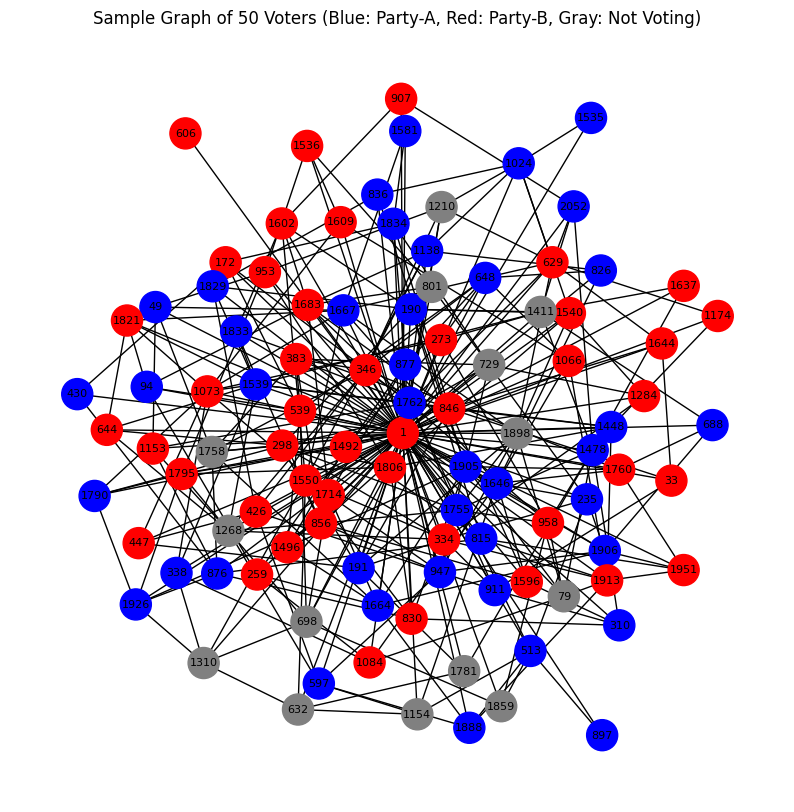

In [38]:
# Sample 200 nodes from the graph
# (to visualize a smaller graph)
sample_nodes = list(G.nodes())[:100]
subgraph = G.subgraph(sample_nodes)

# Create a color map for the nodes based on their decision
# (1: Party-A, 2: Party-B, 3: Not Voting)
# (1: blue, 2: red, 3: gray)
node_colors = []
for node in subgraph.nodes():
    decision = subgraph.nodes[node]['decision']
    if decision == 1:
        node_colors.append('blue')
    elif decision == 2:
        node_colors.append('red')
    else:
        node_colors.append('gray')

# Layout for the nodes
pos = nx.spring_layout(subgraph, seed=42)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_edges(subgraph, pos, edge_color='black')
nx.draw_networkx_labels(subgraph, pos, font_size=8)
plt.title("Sample Graph of 50 Voters (Blue: Party-A, Red: Party-B, Gray: Not Voting)")
plt.axis('off')
plt.show()


## **Question 3**

**Analise how many days does it take to stabilize i.e. no more changing in voting pattern, and determine which candidate wins the race**

In [39]:
def simulate_voting(graph):
    # Create a dictionary for quick lookup of neighbors
    neighbors = {node: list(graph.neighbors(node)) for node in graph.nodes()}
    
    stabilization_days = 0
    daily_changes = []
    
    changed = True
    while changed:
        stabilization_days += 1
        changes_today = 0
        updates = {}  # Store updates for the day
        
        # Iterate through each node in the graph.
        for node in graph.nodes():
            # Only update neutral voters (party == 3)
            if graph.nodes[node]['party'] != 3:
                continue

            count_A = 0
            count_B = 0
            hobbies_node = graph.nodes[node]['hobbies']
            
            # Evaluate influence from each neighbor (friend)
            for friend in neighbors[node]:
                hobbies_friend = graph.nodes[friend]['hobbies']
                common_hobbies = sum(1 for h1, h2 in zip(hobbies_node, hobbies_friend) if h1 == h2)
                
                if common_hobbies >= 3:
                    friend_decision = graph.nodes[friend]['decision']
                    if friend_decision == 1:
                        count_A += 1
                    elif friend_decision == 2:
                        count_B += 1
            
            # Decide new vote based on the majority of influential neighbors.
            new_decision = 3  # Default remains "not voting"
            if count_A > count_B:
                new_decision = 1
            elif count_B > count_A:
                new_decision = 2
            
            # If there is a change in the decision, store the update.
            if new_decision != graph.nodes[node]['decision']:
                updates[node] = new_decision
                changes_today += 1

        # Apply all updates simultaneously.
        for node, new_decision in updates.items():
            graph.nodes[node]['decision'] = new_decision

        daily_changes.append(changes_today)
        
        # If no changes occurred during this day, the system has stabilized.
        if changes_today == 0:
            changed = False
    
    return stabilization_days, daily_changes, graph

# Create a copy of the original graph to avoid modifying it directly.
G_copy = G.copy()

# Run the simulation on the copied graph.
stabilization_days, daily_changes, final_graph = simulate_voting(G_copy)

print("Stabilization achieved after", stabilization_days, "days.")
print("Daily changes:", daily_changes)

# Calculate final vote counts after stabilization.
final_counts = {1: 0, 2: 0, 3: 0}
for node in final_graph.nodes():
    final_counts[final_graph.nodes[node]['decision']] += 1

print("\nFinal Vote Counts:")
print("Party-A (1):", final_counts.get(1, 0))
print("Party-B (2):", final_counts.get(2, 0))
print("Not Voting (3):", final_counts.get(3, 0))

if final_counts.get(1, 0) > final_counts.get(2, 0):
    print("Party-A wins in the steady state.")
elif final_counts.get(2, 0) > final_counts.get(1, 0):
    print("Party-B wins in the steady state.")
else:
    print("It is a tie in the steady state.")


Stabilization achieved after 7 days.
Daily changes: [1302, 747, 622, 579, 102, 3, 0]

Final Vote Counts:
Party-A (1): 3000
Party-B (2): 1000
Not Voting (3): 0
Party-A wins in the steady state.


## **Question 4**

1. **Influencer-1**  
   - **Effect**: Converts all **type-1 music lovers** to vote for **Party-A**  
   - **Condition**: The voter must **not** be a type-1 car lover  
   - **Announcement**: Influencer-1 declares support for **Party-A**

2. **Influencer-2**  
   - **Effect**: Converts all **type-1 car lovers** to vote for **Party-B**  
   - **Condition**: The voter must **not** be a type-1 music lover  
   - **Announcement**: Influencer-2 declares support for **Party-B**

---

##### **Immediate Outcome (Day 2)**

- Both influencers apply their effects on **Day 1**.
- Voters meeting each influencer’s condition immediately update their decisions.
- **Question**: Which candidate leads on **Day 2** (right after the influencers’ intervention)?

---

##### **Further Simulation**

1. **Continue Influence**  
   - After Day 2, let the usual friend/hobby-based influence process run.
   - Neutral voters can still shift to Party-A or Party-B if they share ≥3 hobbies with a majority of their friends.

2. **Stabilization**  
   - The system evolves day by day until no one changes decision anymore.
   - **Question**: How many days until final stabilization?
   - **Result**: Which candidate ultimately wins?



In [45]:
# Step 1: Deep copy graph and apply influencer effects
G_influencer = copy.deepcopy(G)

for node in G_influencer.nodes():
    music, car = G_influencer.nodes[node]['hobbies'][:2]
    if music == 1 and car != 1:
        G_influencer.nodes[node]['decision'] = 1  # Party-A
    elif car == 1 and music != 1:
        G_influencer.nodes[node]['decision'] = 2  # Party-B

# Step 2: Initial vote count (G4)
state_day1 = {1: 0, 2: 0, 3: 0}
for node in G_influencer.nodes():
    state_day1[G_influencer.nodes[node]['decision']] += 1

print("🟩 G4 - After influencer effect (Day 1):")
print("Party-A:", state_day1[1])
print("Party-B:", state_day1[2])
print("Not voting:", state_day1[3])
print()

# Step 3: Prepare simulation
neighbors_inf = {node: list(G_influencer.neighbors(node)) for node in G_influencer.nodes()}
daily_states = [state_day1.copy()]
daily_changes_inf = []
stabilization_days_inf = 1  # Start from Day 1

changed = True
while changed:
    stabilization_days_inf += 1
    changes_today = 0
    updates = {}

    for node in G_influencer.nodes():
        if G_influencer.nodes[node]['party'] != 3:
            continue

        count_A = 0
        count_B = 0
        hobbies_node = G_influencer.nodes[node]['hobbies']

        for friend in neighbors_inf[node]:
            hobbies_friend = G_influencer.nodes[friend]['hobbies']
            common = sum(1 for a, b in zip(hobbies_node, hobbies_friend) if a == b)
            if common >= 3:
                decision = G_influencer.nodes[friend]['decision']
                if decision == 1:
                    count_A += 1
                elif decision == 2:
                    count_B += 1

        new_decision = 3
        if count_A > count_B:
            new_decision = 1
        elif count_B > count_A:
            new_decision = 2

        if new_decision != G_influencer.nodes[node]['decision']:
            updates[node] = new_decision
            changes_today += 1

    for node, new_decision in updates.items():
        G_influencer.nodes[node]['decision'] = new_decision

    daily_changes_inf.append(changes_today)

    # Count new state
    state_today = {1: 0, 2: 0, 3: 0}
    for node in G_influencer.nodes():
        state_today[G_influencer.nodes[node]['decision']] += 1
    daily_states.append(state_today)

    # Print day-to-day change
    prev = daily_states[-2]
    curr = state_today
    print(f"📆 Day {stabilization_days_inf - 1} ➝ Day {stabilization_days_inf}: "
          f"Party-A = {curr[1]}, Party-B = {curr[2]}, Not voting = {curr[3]}")

    # --- G42: Who wins on Day 2?
    if stabilization_days_inf == 2:
        winner_day2 = "Party-A" if curr[1] > curr[2] else "Party-B" if curr[2] > curr[1] else "Tie"
        print(f"🏅 G42 - Winner on Day 2: {winner_day2}\n")

    if changes_today == 0:
        changed = False

# Final Day: G43
final_state = daily_states[-1]
print("\n🟥 G43 - After stabilization:")
print("Days to stabilize:", stabilization_days_inf - 1)
print("Final Party-A:", final_state[1])
print("Final Party-B:", final_state[2])
print("Final Not voting:", final_state[3])

winner_final = "Party-A" if final_state[1] > final_state[2] else "Party-B" if final_state[2] > final_state[1] else "Tie"
print("🏁 Final Winner:", winner_final)


🟩 G4 - After influencer effect (Day 1):
Party-A: 1806
Party-B: 1841
Not voting: 353

📆 Day 1 ➝ Day 2: Party-A = 1930, Party-B = 2027, Not voting = 43
🏅 G42 - Winner on Day 2: Party-B

📆 Day 2 ➝ Day 3: Party-A = 1891, Party-B = 2057, Not voting = 52
📆 Day 3 ➝ Day 4: Party-A = 1840, Party-B = 2116, Not voting = 44
📆 Day 4 ➝ Day 5: Party-A = 1711, Party-B = 2246, Not voting = 43
📆 Day 5 ➝ Day 6: Party-A = 1439, Party-B = 2527, Not voting = 34
📆 Day 6 ➝ Day 7: Party-A = 1149, Party-B = 2841, Not voting = 10
📆 Day 7 ➝ Day 8: Party-A = 1011, Party-B = 2983, Not voting = 6
📆 Day 8 ➝ Day 9: Party-A = 986, Party-B = 3010, Not voting = 4
📆 Day 9 ➝ Day 10: Party-A = 984, Party-B = 3013, Not voting = 3
📆 Day 10 ➝ Day 11: Party-A = 984, Party-B = 3013, Not voting = 3

🟥 G43 - After stabilization:
Days to stabilize: 10
Final Party-A: 984
Final Party-B: 3013
Final Not voting: 3
🏁 Final Winner: Party-B


# Question 5

In [48]:
friend_cols = [col for col in data.columns if col.startswith('friend_')]
data['friends'] = data[friend_cols].values.tolist()


In [50]:
print("\n🎯 Task 5 - Hobby Influence Analysis")
results = {}

for hobby in hobby_cols:
    df_influencer = data.copy()
    
    # Find most common type for the current hobby
    mode_val = df_influencer[hobby].mode().iloc[0]
    print(f"\n👉 Hobby: {hobby} | Most common type: {mode_val}")
    
    # Influencer converts all voters with this hobby type to vote Party-A
    mask = df_influencer[hobby] == mode_val
    df_influencer.loc[mask, 'decision'] = 1
    
    # Convert data for simulation
    n = len(df_influencer)
    decisions = df_influencer['decision'].to_numpy(dtype=np.int32)
    party = df_influencer['party'].to_numpy(dtype=np.int32)
    hobbies = df_influencer[hobby_cols].to_numpy(dtype=np.int32)
    
    neighbors = List()
    for idx in range(n):
        friend_ids = df_influencer.iloc[idx]['friends']
        if len(friend_ids) > 0:
            arr = np.array(friend_ids, dtype=np.int32) - 1
        else:
            arr = np.empty(0, dtype=np.int32)
        neighbors.append(arr)
    
    # Run simulation
    final_decisions, days, _ = simulate_influence_numba(decisions, party, hobbies, neighbors)
    unique, counts = np.unique(final_decisions, return_counts=True)
    final_vote_counts = dict(zip(unique, counts))
    party_a = final_vote_counts.get(1, 0)

    results[hobby] = {'Party_A_final': party_a, 'stabilization_days': days, 'type': mode_val}
    print(f"✅ After simulation: Party-A = {party_a}, Stabilized in {days} days.")

# Find best hobby
best_hobby = max(results, key=lambda k: results[k]['Party_A_final'])
best_info = results[best_hobby]

print("\n🏁 Task 5 Summary:")
print(f"📌 Best hobby for influence: **{best_hobby}**")
print(f"➡️ Influencing type-{best_info['type']} voters gave Party-A {best_info['Party_A_final']} votes")
print(f"🕒 Stabilization reached in {best_info['stabilization_days']} days")



🎯 Task 5 - Hobby Influence Analysis

👉 Hobby: hobby_music | Most common type: 3
✅ After simulation: Party-A = 3339, Stabilized in 3 days.

👉 Hobby: hobby_car | Most common type: 1
✅ After simulation: Party-A = 3350, Stabilized in 4 days.

👉 Hobby: hobby_sports | Most common type: 2
✅ After simulation: Party-A = 3799, Stabilized in 3 days.

👉 Hobby: hobby_movie | Most common type: 3
✅ After simulation: Party-A = 3798, Stabilized in 2 days.

👉 Hobby: hobby_food | Most common type: 3
✅ After simulation: Party-A = 3792, Stabilized in 2 days.

🏁 Task 5 Summary:
📌 Best hobby for influence: **hobby_sports**
➡️ Influencing type-2 voters gave Party-A 3799 votes
🕒 Stabilization reached in 3 days
